In [652]:
from rdkit import Chem
import numpy as np 
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec 
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut

from gensim.models import word2vec

from tqdm import tqdm

from rdkit import rdBase

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor, kernels as K
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, GridSearchCV

import pandas as pd
from sklearn.metrics import r2_score
import csv
polymer_embedding_model = word2vec.Word2Vec.load('POLYINFO_PI1M.pkl')


In [653]:
with open('Initial training set.csv') as csvfile:
  reader = csv.reader(csvfile)
  rows = [row for row in reader]
data = np.array(rows)
data = np.delete(data, 0, axis=0)
sentences = list()
smiles = list(data[:,0])

# the following 4 lines are important to understand how the encoding process works (I can also not explain them explicitly to you :D)
for i in range(len(smiles)):
    sentence = MolSentence(mol2alt_sentence(Chem.MolFromSmiles(smiles[i]), 1))
    sentences.append(sentence)

polymer_embeddings = [DfVec(x) for x in sentences2vec(sentences, polymer_embedding_model, unseen='UNK')]
X = np.array([x.vec.tolist() for x in polymer_embeddings]) #X as feature matrix
print(X)

df = pd.DataFrame(X)

# Save the DataFrame to a CSV file
# df.to_csv('X.csv', index=False)
# Standardize the features

scaler = StandardScaler()
X = scaler.fit_transform(X)

[[  1.14834082   1.5373522   -0.91155183 ...  -1.26318848  -0.6738013
    1.62282288]
 [  1.05136561   1.82333279  -0.8785184  ...  -1.5370065   -0.79291677
    1.935588  ]
 [  2.05619788   1.60823953  -1.27762079 ...  -2.26807094  -0.9773134
    3.2950809 ]
 ...
 [ -6.87632895   7.21895742  12.42747021 ... -37.78458786 -10.14152527
   22.64035606]
 [ -8.29130077  10.05173397  15.92770576 ... -47.04550552 -10.85881233
   29.67038155]
 [-13.68489933   7.4299283   12.75312328 ... -41.02780914  -5.69918251
   23.57221031]]


array([[ 0.57521585, -0.60442282, -0.07924641, ...,  0.81180231,
         1.1655383 , -0.34353224],
       [ 0.54926232, -0.50541398, -0.07306083, ...,  0.7875232 ,
         1.13576495, -0.30557072],
       [ 0.81818625, -0.57988104, -0.14779369, ...,  0.72270063,
         1.08967435, -0.14056378],
       ...,
       [-1.57243187,  1.36259598,  2.41851702, ..., -2.42650475,
        -1.2009536 ,  2.20744752],
       [-1.95112172,  2.34332669,  3.07394441, ..., -3.2476588 ,
        -1.3802421 ,  3.06070906],
       [-3.3946141 ,  1.43563584,  2.47949633, ..., -2.71407715,
        -0.09057394,  2.3205503 ]])

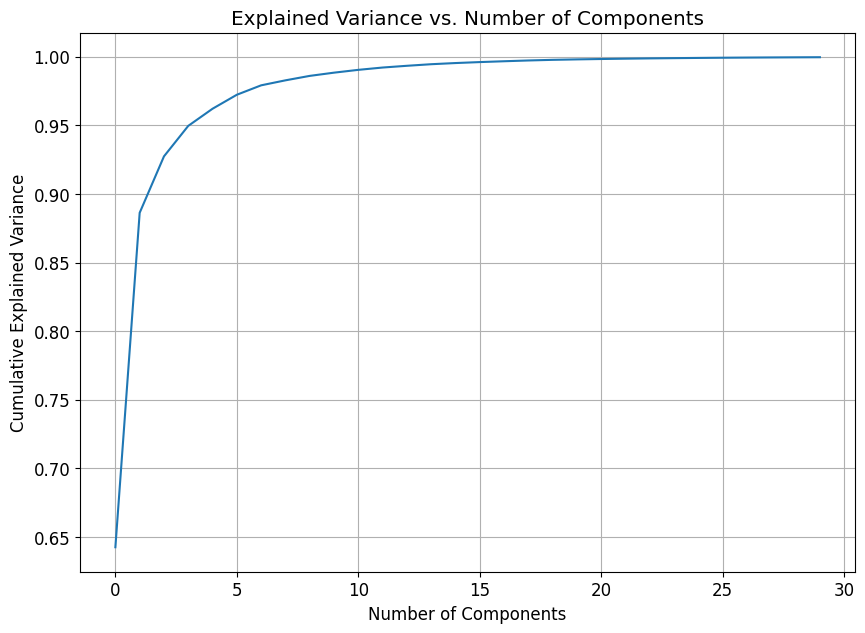

Optimal number of components: 11


In [654]:
pca = PCA(n_components=30)
pca_result = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_variance)
optimal_components = np.argmax(cum_var >= 0.99) + 1  # 95% variance
print(f"Optimal number of components: {optimal_components}")
pca_optimal = PCA(n_components=optimal_components)
X = pca_optimal.fit_transform(X)

In [657]:
y = np.array(data[:,1]).astype(np.float64)  #y as lable
print(y)
embedding_dimension = len(polymer_embeddings[0].vec) if len(polymer_embeddings) > 0 else 0
print(f"Dimension of each embedding: {embedding_dimension}")
print(X.shape)
df = pd.DataFrame(X)

[0.384      0.283      0.26       0.26       0.401      0.267
 0.175      0.801      0.651      0.231      0.474      0.238
 0.361      0.148      0.465      0.304      0.673      0.221
 0.248      0.261      0.726      0.222      0.157      0.314
 0.233      0.148      0.301      0.65       0.597      0.559
 0.668      0.66       0.221      0.282      0.271      0.926
 0.741      0.72566667 0.605      0.743      0.525      0.527
 1.086      0.412      0.406      0.394     ]
Dimension of each embedding: 300
(46, 9)


RationalQuadratic(alpha=0.0658, length_scale=74.8) + WhiteKernel(noise_level=0.00592)
0.838626372099229
0.11193436426827072
0.0623034074380448
0.030505592751218977


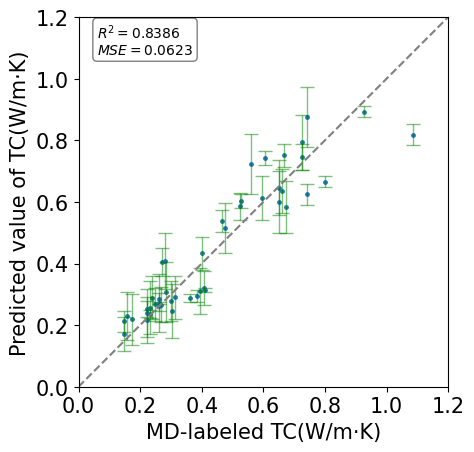

In [658]:
MSEs = [] # mean square error
R2s = [] # coefficient of determination
gpr = GaussianProcessRegressor(
    kernel= K.RationalQuadratic() + K.WhiteKernel(),
    alpha=1e-4,
    random_state=42,
)
# gpr = clf.best_estimator_
gpr.fit(X,y)
print(gpr.kernel_)
kf = KFold(n_splits=5)

y_true_plot=[]
y_pred_plot=[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y[train_index], y[test_index]
    gpr = GaussianProcessRegressor(
        kernel=K.RationalQuadratic(alpha_bounds='fixed', alpha=0.0341, length_scale=51, length_scale_bounds='fixed') + K.WhiteKernel(noise_level=0.00253, noise_level_bounds='fixed'),
        alpha=1e-4,
        n_restarts_optimizer=100,
        random_state=42,
    )
    gpr.fit(X_train, y_train) #use the training data to fit the model
    y_pred, y_teststd = gpr.predict(X_test, return_std=True) # use the trained model to make prediction
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    R2s.append(r2)
    MSEs.append(mae)
    y_true_plot.extend(y_test)
    y_pred_plot.extend(gpr.predict(X_test))
print(np.mean(R2s))
print(np.std(R2s))
print(np.mean(MSEs))
print(np.std(MSEs))

fig, ax = plt.subplots()
plt.scatter(y_true_plot, y_pred_plot,s=6)
y_teststd = np.random.rand(len(y_true_plot)) * 0.1
plt.errorbar(y_true_plot, y_pred_plot, yerr=y_teststd, fmt='none', capsize =5, elinewidth = 1, c='green', alpha=0.5)
plt.plot([0, 1.2], [0, 1.2], 'gray', linestyle='--')

bbox = dict(boxstyle="round", fc='1',alpha=0.5)
# plt.annotate('$R^2=%.2f$' % (np.mean(R2s)), (0.05, 0.9), size=10, bbox=bbox, xycoords='axes fraction')
# plt.annotate('$MSE=%.2f$' % (np.mean(MSEs)), (0.05, 0.85), size=10, bbox=bbox, xycoords='axes fraction')
annotation_text = '$R^2=%.4f$\n$MSE=%.4f$' % (np.mean(R2s), np.mean(MSEs))
plt.annotate(annotation_text, (0.05, 0.9), size=10, bbox=bbox, xycoords='axes fraction')
plt.xlabel("MD-labeled TC(W/m·K)", fontsize=15)
plt.ylabel("Predicted value of TC(W/m·K)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
mpl.rcParams['font.size'] = 12
plt.axis('square')
plt.xlim(0, 1.2)
plt.ylim(0, 1.2)

In [659]:
gpr = GaussianProcessRegressor(
    kernel= K.RationalQuadratic() + K.WhiteKernel(),
    alpha=1e-4,
    random_state=42,
)
gpr.fit(X, y)
y_mean, y_std = gpr.predict(X, return_std=True)
print(y_mean)
print(y_std)

[0.27815572 0.29135633 0.25610829 0.26710435 0.43579163 0.27550461
 0.23538865 0.67934953 0.59937341 0.25070086 0.52809956 0.2452182
 0.26960093 0.18102317 0.53578435 0.24801059 0.59243283 0.22119555
 0.27307276 0.29087412 0.77208871 0.23283788 0.23007236 0.30525996
 0.26479715 0.15289354 0.27091897 0.63015126 0.59143887 0.66002583
 0.67704191 0.60807439 0.2311602  0.28132179 0.2850064  0.80795897
 0.82640166 0.84039675 0.67150778 0.7515872  0.57243411 0.58144026
 0.80795897 0.40050497 0.40814677 0.38748376]
[0.08146056 0.0810842  0.08115728 0.08983995 0.08258414 0.08212887
 0.08227287 0.08368725 0.08629698 0.08135817 0.0817298  0.08497847
 0.08052551 0.0869085  0.08460816 0.0838053  0.08220589 0.08346849
 0.07987146 0.08000651 0.0912901  0.08270847 0.08418915 0.0804319
 0.08259292 0.09704042 0.08159246 0.08595096 0.08265492 0.08211066
 0.08201533 0.08332231 0.09272151 0.09657237 0.0951091  0.08210302
 0.08330804 0.08516527 0.08269193 0.10212209 0.08462175 0.08406464
 0.08210302 0.1003

In [660]:
df = pd.read_csv('./dataset2_pred.csv')

# the following 4 lines are important to understand how the encoding process works (I can also not explain them explicitly to you :D)
sentences = []
smiles = df['SMILES'].values
for i in range(len(smiles)):
    sentence = MolSentence(mol2alt_sentence(Chem.MolFromSmiles(smiles[i]), 1))
    sentences.append(sentence)

polymer_embeddings = [DfVec(x) for x in sentences2vec(sentences, polymer_embedding_model, unseen='UNK')]
X = np.array([x.vec.tolist() for x in polymer_embeddings]) #X as feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [661]:
#  Apply PCA
pca_optimal = PCA(n_components=optimal_components)
X = pca_optimal.fit_transform(X)

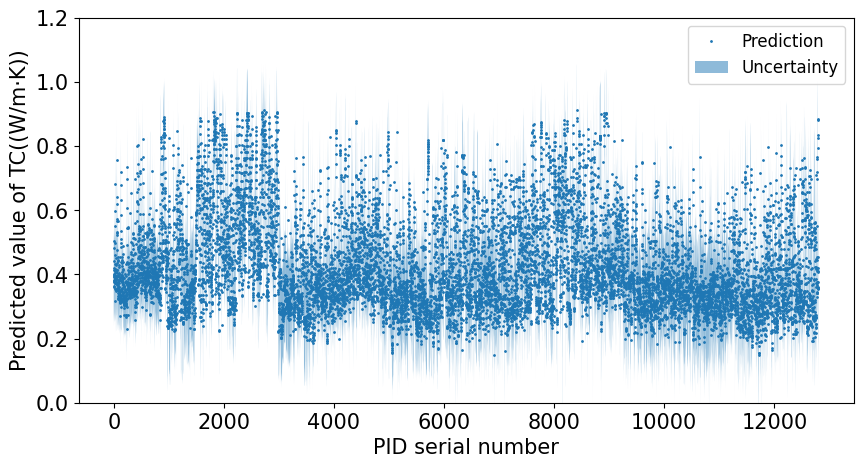

In [662]:
y_mean, y_std = gpr.predict(X, return_std=True)

df['TC_pred'] = y_mean
df['TC_std'] = y_std
df.to_csv('dataset2_pred2.csv', index=False)

plt.figure(figsize=(10, 5))
# idx = np.argsort(y_mean)
# y_mean = y_mean[idx]
# y_std = y_std[idx]
plt.plot(np.arange(len(y_mean)), y_mean, '.', label='Prediction', ms=2)
plt.fill_between(np.arange(len(y_mean)), y_mean - y_std, y_mean + y_std, alpha=0.5, label='Uncertainty')
#plt.plot(np.arange(len(y_mean)), y, label='True value')
plt.legend(loc='upper right')
plt.xlabel("PID serial number", fontsize=15)
plt.ylabel("Predicted value of TC((W/m·K))", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
mpl.rcParams['font.size'] = 12
plt.ylim(0, 1.2)

In [ ]:
# Load the dataset
df = pd.read_csv("dataset2_pred.csv")
PID = df['PID'].values
tc_pred = df['TC_pred'].values
tc_std = df['TC_std'].values

# Compute the best TC value so far
best_tc = np.max(tc_pred)

# Exploration preference parameter
xi = 0.01

# Compute the Expected Improvement for each polymer
Z = (tc_pred - best_tc - xi) / tc_std
expected_improvement = (tc_pred - best_tc - xi) * norm.cdf(Z) + tc_std * norm.pdf(Z)

log_expected_improvement = np.log(expected_improvement)

best_index = np.argmax(log_expected_improvement)

print("Next-best polymer to sample: ", PID[best_index])

df_ei = pd.DataFrame({
    'PID': PID,
    'EI': log_expected_improvement
})
df_ei.to_csv('expected_improvement.csv', index=False)

x = np.arange(len(PID))

#plot
plt.figure(figsize=(12, 6))
plt.bar(PID, log_expected_improvement)
plt.xlabel('PID')
plt.ylabel('Log Expected Improvement')
plt.title('Log Expected Improvement for each Polymer')
plt.xticks(np.arange(min(x), max(x)+1, 2000))
plt.tight_layout()
plt.savefig('log_expected_improvement.png')
plt.show()